
In this notebook, You will do amazon review classification with BERT.[Download data from [this](https://www.kaggle.com/snap/amazon-fine-food-reviews/data) link]
<pre> 
It contains 5 parts as below.  Detailed instrctions are given in the each cell. please read every comment we have written. 
    1. Preprocessing 
    2. Creating a BERT model from the Tensorflow HUB.
    3. Tokenization
    4. getting the pretrained embedding Vector for a given review from the BERT.
    5. Using the embedding data apply NN and classify the reviews.
    6. Creating a Data pipeline for BERT Model. 

<font size=5>instructions:</font>

    1. Don't change any Grader Functions. Don't manipulate any Grader functions. 
    If you manipulate any, it will be considered as plagiarised. 
    
    2. Please read the instructions on the code cells and markdown cells. We will explain what to write. 
    
    3. please return outputs in the same format what we asked. Eg. Don't return List if we are asking for a numpy array.
    
    4. Please read the external links that we are given so that you will learn the concept behind the code that you are writing.
    
    5. We are giving instructions at each section if necessary, please follow them. 

<font size=5>Every Grader function has to return True. </font>
</pre>

In [1]:
#in this assignment you need two files reviews.csv and tokenization file
#you can use gdown module to import both the files in colab from Google drive
#the syntax is for gdown is !gdown --id file_id
#please run the below cell to import the required files


In [2]:
# !gdown --id 1GsD8JlAc_0yJ-1151LNr6rLw83RRUPgt
# !gdown --id 13exfXiyiByluh1PfYK1EyZyizqxeCVG9

In [3]:
#all imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

<font size=4>Grader function 1 </font>

In [5]:
def grader_tf_version():
    assert((tf.__version__)>'2')
    return True
grader_tf_version()

True

<pre><font size=6>Part-1: Preprocessing</font></pre>

In [6]:
#Read the dataset - Amazon fine food reviews
reviews = pd.read_csv(r"C:\Users\SVF\Downloads\IPYNB\AAIC Assignments\28. NLP with Transfer Learning\Reviews.csv")

#check the info of the dataset
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [7]:
# get only 2 columns - Text, Score
reviews = reviews[['Text', 'Score']]

#drop the NAN values
reviews = reviews.dropna()

In [8]:
# if score == 3, remove the rows
reviews = reviews[reviews.Score != 3]

# if score> 3, set score = 1
# if score<=2, set score = 0
reviews['Score'] = np.where(reviews['Score'] > 3, 1, 0)

<font size=4>Grader function 2 </font>

In [9]:
def grader_reviews():
    temp_shape = (reviews.shape == (525814, 2)) and (reviews.Score.value_counts()[1]==443777)
    assert(temp_shape == True)
    return True
grader_reviews()

True

In [10]:
def get_wordlen(x):
    return len(x.split())
reviews['len'] = reviews.Text.apply(get_wordlen)
reviews = reviews[reviews.len<50]
reviews = reviews.sample(n=100000, random_state=30)

In [11]:
import re
# remove HTML from the Text column and save in the Text column only
reviews['Text'] = reviews['Text'].str.replace(r'<[^<>]*>', '', regex=True)

In [12]:
# print head 5
reviews.head()

,Text,Score,len
64117,The tea was of great quality and it tasted lik...,1,30
418112,My cat loves this. The pellets are nice and s...,1,31
357829,Great product. Does not completely get rid of ...,1,41
175872,This gum is my favorite! I would advise every...,1,27
178716,I also found out about this product because of...,1,22


In [13]:
X = reviews[['Text', 'len']]
y = reviews['Score']

#split the data into train and test data(20%) with Stratify sampling, random state 33.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

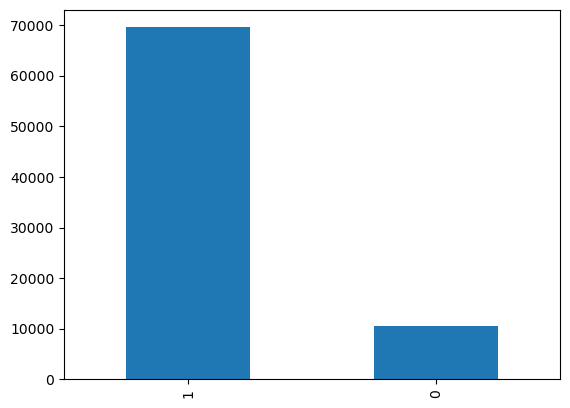

In [14]:
#plot bar graphs of y_train and y_test

y_train.value_counts().plot(kind = 'bar')
plt.show()

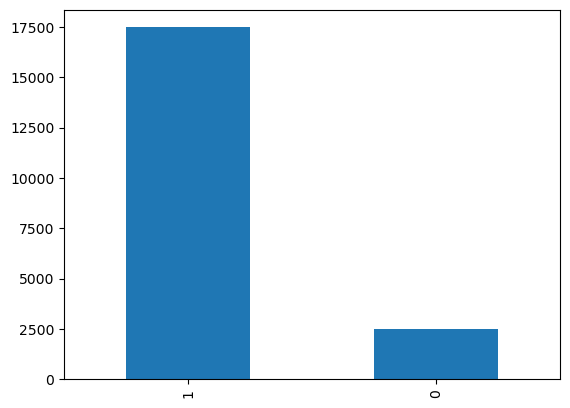

In [15]:
y_test.value_counts().plot(kind = 'bar')
plt.show()

In [16]:
#saving to disk. if we need, we can load preprocessed data directly. 
reviews.to_csv('preprocessed.csv', index=False)

<pre><font size=6>Part-2: Creating BERT Model</font> 

If you want to know more about BERT, You can watch live sessions on Transformers and BERt. 
we will strongly recommend you to read <a href="https://jalammar.github.io/illustrated-transformer/">Transformers</a>, <a href="https://arxiv.org/abs/1810.04805">BERT Paper</a> and, <a href="https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/">This blog</a>.


For this assignment, we are using <a href="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1">BERT uncased Base model</a>. 
It uses L=12 hidden layers (i.e., Transformer blocks), a hidden size of H=768, and A=12 attention heads. </pre>

In [17]:
## Loading the Pretrained Model from tensorflow HUB
tf.keras.backend.clear_session()

# maximum length of a seq in the data we have, for now i am making it as 55. You can change this
max_seq_length = 55

#BERT takes 3 inputs

#this is input words. Sequence of words represented as integers
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

#mask vector if you are padding anything
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

#segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
#If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
#second seq segment vector are 1's
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

#bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

#Bert model
#We are using only pooled output not sequence out. 
#If you want to know about those, please read https://www.kaggle.com/questions-and-answers/86510
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)


In [18]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 55)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 55)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 55)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 55, 768)]                 'input_mask[0][0]',         

In [19]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

<pre><font size=6>Part-3: Tokenization</font></pre>

In [20]:
# getting Vocab file
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [21]:
import tokenization # We have given tokenization.py file

In [22]:
# Create tokenizer " Instantiate FullTokenizer" 
# name must be "tokenizer"
# the FullTokenizer takes two parameters 1. vocab_file and 2. do_lower_case 
# we have created these in the above cell ex: FullTokenizer(vocab_file, do_lower_case )
# please check the "tokenization.py" file the complete implementation
tokenizer=tokenization.FullTokenizer(vocab_file,do_lower_case )

<font size=4>Grader function 3 </font>

In [23]:
#it has to give no error 
def grader_tokenize(tokenizer):
    out = False
    try:
        out=('[CLS]' in tokenizer.vocab) and ('[SEP]' in tokenizer.vocab)
    except:
        out = False
    assert(out==True)
    return out
grader_tokenize(tokenizer)

True

In [24]:
# Create train and test tokens (X_train_tokens, X_test_tokens) from (X_train, X_test) using Tokenizer and 

# add '[CLS]' at start of the Tokens and '[SEP]' at the end of the tokens. 

# maximum number of tokens is 55(We already given this to BERT layer above) so shape is (None, 55)

# if it is less than 55, add '[PAD]' token else truncate the tokens length.(similar to padding)

# Based on padding, create the mask for Train and Test ( 1 for real token, 0 for '[PAD]'), 
# it will also same shape as input tokens (None, 55) save those in X_train_mask, X_test_mask

# Create a segment input for train and test. We are using only one sentence so all zeros. This shape will also (None, 55)

# type of all the above arrays should be numpy arrays

# after execution of this cell, you have to get 
# X_train_tokens, X_train_mask, X_train_segment
# X_test_tokens, X_test_mask, X_test_segment

#### Example
<img src='https://i.imgur.com/5AhhmgU.png'>

In [25]:
def tokenize(sentence):    
    
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[0:(max_seq_length - 2)]
    tokens = ['[CLS]',*tokens,'[SEP]']

    token = np.array(tokenizer.convert_tokens_to_ids(tokens) + [0] * (max_seq_length - len(tokens)))
    mask = np.array([1] * len(tokens) + [0] * (max_seq_length - len(tokens)))
    segment = np.array([0] * max_seq_length) 
    
    return token, mask, segment

In [26]:
from tqdm import tqdm

X_train_tokens= []
X_train_mask = []
X_train_segment = []

for sent in tqdm(range(len(X_train))):
    res = X_train.values[sent][0]
    t, m, s = tokenize(res)
    
    X_train_tokens.append(t)
    X_train_mask.append(m)
    X_train_segment.append(s)

100%|████████████████████████████████████████████████████████████████████████████| 80000/80000 [20:00<00:00, 66.65it/s]


In [27]:
X_train_tokens = np.array(X_train_tokens)
X_train_mask = np.array(X_train_mask)
X_train_segment = np.array(X_train_segment)

print(type(X_train_tokens), type(X_train_mask), type(X_train_segment))
print(X_train_tokens.shape, X_train_mask.shape, X_train_segment.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(80000, 55) (80000, 55) (80000, 55)


In [28]:
X_test_tokens = []
X_test_mask = []
X_test_segment = []

for sent in tqdm(range(len(X_test))):
    res = X_test.values[sent][0]
    t_, m_, s_ = tokenize(res)
    
    X_test_tokens.append(t_)
    X_test_mask.append(m_)
    X_test_segment.append(s_)

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:45<00:00, 189.11it/s]


In [29]:
X_test_tokens = np.array(X_test_tokens)
X_test_mask = np.array(X_test_mask)
X_test_segment = np.array(X_test_segment)

print(X_test_tokens.shape, X_test_mask.shape, X_test_segment.shape)

(20000, 55) (20000, 55) (20000, 55)


In [30]:
import pickle

In [31]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train, X_train_tokens, X_train_mask, X_train_segment, y_train),open('train_data.pkl','wb'))
pickle.dump((X_test, X_test_tokens, X_test_mask, X_test_segment, y_test),open('test_data.pkl','wb'))

In [32]:
#you can load from disk
#X_train, X_train_tokens, X_train_mask, X_train_segment, y_train = pickle.load(open("train_data.pkl", 'rb')) 
#X_test, X_test_tokens, X_test_mask, X_test_segment, y_test = pickle.load(open("test_data.pkl", 'rb')) 

<font size=4>Grader function 4 </font>

In [33]:
def grader_alltokens_train():
    out = False
    
    if type(X_train_tokens) == np.ndarray:
        
        temp_shapes = (X_train_tokens.shape[1]==max_seq_length) and (X_train_mask.shape[1]==max_seq_length) and \
        (X_train_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_train_segment)
        
        mask_temp = np.sum(X_train_mask==0) == np.sum(X_train_tokens==0)
        
        no_cls = np.sum(X_train_tokens==tokenizer.vocab['[CLS]'])==X_train_tokens.shape[0]
        
        no_sep = np.sum(X_train_tokens==tokenizer.vocab['[SEP]'])==X_train_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out

grader_alltokens_train()

True

<font size=4>Grader function 5 </font>

In [34]:
def grader_alltokens_test():
    out = False
    if type(X_test_tokens) == np.ndarray:
        
        temp_shapes = (X_test_tokens.shape[1]==max_seq_length) and (X_test_mask.shape[1]==max_seq_length) and \
        (X_test_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_test_segment)
        
        mask_temp = np.sum(X_test_mask==0) == np.sum(X_test_tokens==0)
        
        no_cls = np.sum(X_test_tokens==tokenizer.vocab['[CLS]'])==X_test_tokens.shape[0]
        
        no_sep = np.sum(X_test_tokens==tokenizer.vocab['[SEP]'])==X_test_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out
grader_alltokens_test()

True

<pre><font size=6>Part-4: Getting Embeddings from BERT Model</font>
We already created the BERT model in the part-2 and input data in the part-3. 
We will utlize those two and will get the embeddings for each sentence in the 
Train and test data.</pre>

In [35]:
bert_model.input

[<KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_word_ids')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_mask')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'segment_ids')>]

In [36]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

In [37]:
# get the train output, BERT model will give one output so save in
# X_train_pooled_output
#this cell will take some time to execute, make sure thay you have stable internet connection
X_train_pooled_output=bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])

2500/2500 [==============================] - 4326s 2s/step


In [38]:
# get the test output, BERT model will give one output so save in
# X_test_pooled_output
X_test_pooled_output=bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])

625/625 [==============================] - 1087s 2s/step


In [39]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train_pooled_output, X_test_pooled_output),open('final_output.pkl','wb'))

In [40]:
#X_train_pooled_output, X_test_pooled_output= pickle.load(open('final_output.pkl', 'rb'))

<font size=4>Grader function 6 </font>

In [41]:
#now we have X_train_pooled_output, y_train
#X_test_pooled_ouput, y_test

#please use this grader to evaluate
def greader_output():
    assert(X_train_pooled_output.shape[1]==768)
    assert(len(y_train)==len(X_train_pooled_output))
    assert(X_test_pooled_output.shape[1]==768)
    assert(len(y_test)==len(X_test_pooled_output))
    assert(len(y_train.shape)==1)
    assert(len(X_train_pooled_output.shape)==2)
    assert(len(y_test.shape)==1)
    assert(len(X_test_pooled_output.shape)==2)
    return True
greader_output()

True

<pre><font size=6>Part-5: Training a NN with 768 features</font>

Create a NN and train the NN. 
1.<b> You have to use AUC as metric. Do not use tf.keras.metrics.AUC</b> 
<b> You have to write custom code for AUC and print it at the end of each epoch</b> 
2. You can use any architecture you want. 
3. You have to use tensorboard to log all your metrics and Losses. You have to send those logs. 
4. Print the loss and metric at every epoch. 
5. You have to submit without overfitting and underfitting. 
</pre>

In [42]:
##imports
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, LSTM
from tensorflow.keras.models import Model

In [43]:
##create an Neural Network and train your model on X_train_pooled_output and y_train
# you can start as follows
input_layer = Input(shape=(X_train_pooled_output.shape[1],))

X = Dense(128, activation="relu", kernel_initializer="he_normal")(input_layer)
X = Dense(64, activation="relu", kernel_initializer="he_normal")(X)
X = Dense(32, activation="relu", kernel_initializer="he_normal")(X)
X = Dense(16, activation="relu", kernel_initializer="he_normal")(X)

output = Dense(2, activation="softmax")(X)

model = Model(inputs=[input_layer], outputs=[output])

In [44]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 2)                 34        
                                                                 
Total params: 109,330
Trainable params: 109,330
Non-trainab

In [45]:
from sklearn.metrics import roc_auc_score

def auc_roc(y_true, y_pred):
    return tensorflow.compat.v1.py_func(roc_auc_score, (y_true, y_pred), tensorflow.double)

In [46]:
import datetime
import tensorflow

%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/ 

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [47]:
d_train = [X_train_pooled_output]
d_test = [X_test_pooled_output]

In [48]:
y_train_ohe =pd.get_dummies(y_train)
y_test_ohe = pd.get_dummies(y_test)

In [49]:
model.compile(optimizer=tensorflow.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=[auc_roc])

In [50]:
history = model.fit(d_train, y_train_ohe, batch_size=128, epochs=25, callbacks=[tensorboard_callback], validation_data=(d_test, y_test_ohe)) 

Epoch 1/25
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


625/625 [==============================] - 13s 18ms/step - loss: 0.2570 - auc_roc: 0.8972 - val_loss: 0.2008 - val_auc_roc: 0.9412
Epoch 2/25
625/625 [==============================] - 10s 17ms/step - loss: 0.2070 - auc_roc: 0.9440 - val_loss: 0.1838 - val_auc_roc: 0.9472
Epoch 3/25
625/625 [==============================] - 11s 17ms/step - loss: 0.1976 - auc_roc: 0.9482 - val_loss: 0.1844 - val_auc_roc: 0.9491
Epoch 4/25
625/625 [==============================] - 11s 17ms/step - loss: 0.1926 - auc_roc: 0.9499 - val_loss: 0.1826 - val_auc_roc: 0.9517
Epoch 5/25
625/625 [==============================] - 11s 17ms/step - loss: 0.1905 - auc_roc: 0.9516 - val_loss: 0.1991 - val_auc_roc: 0.9516
Epoch 6/25
625/625 [==============================] - 11s 17ms/step - loss: 0.1859 - auc_roc: 0.9538 - val_loss: 0.1947 - val_auc_roc: 0.9539
Epoch 7/25
625/625 [==============================] - 11s 18ms/step - loss: 0.1839 - auc_roc: 0.9547 - val_loss: 0.1794 - val_auc_roc: 0.9546
Epoch 8/25
625/62

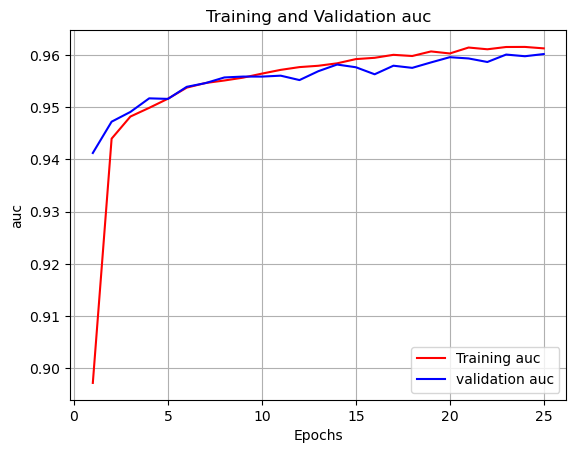

In [51]:
train_auc = history.history['auc_roc'] 
test_auc = history.history['val_auc_roc']
epochs = range(1,26)

plt.plot(epochs, train_auc, 'r', label='Training auc')
plt.plot(epochs, test_auc, 'b', label='validation auc')
plt.title('Training and Validation auc')
plt.xlabel('Epochs')
plt.ylabel('auc')
plt.legend()
plt.grid()
plt.show()

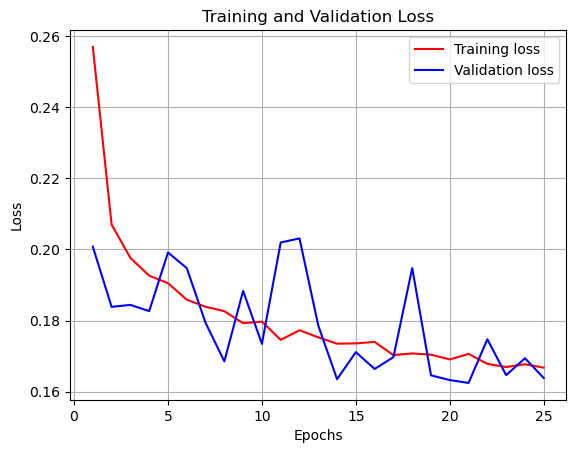

In [52]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
epochs = range(1,26)

plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, test_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

<Pre><font size=6>Part-6: Creating a Data pipeline for BERT Model</font> 
1. Pipeline is a way to codify and automate the workflow.
2. Download the test.csv file from here <a href="https://drive.google.com/file/d/1QwjqTsqTX2vdy7fTmeXjxP3dq8IAVLpo/view?usp=sharing">here</a> </pre>


In [53]:
#there is an alterante way to load files from Google drive directly to your Colab session
# you can use gdown module to import the files as follows
#for example for test.csv you can write your code as !gdown --id file_id (remove the # from next line and run it)

In [54]:
#read the csv file
test_df= pd.read_csv(r'C:\Users\SVF\Downloads\IPYNB\AAIC Assignments\28. NLP with Transfer Learning\test.csv')
test_df.head()

,Text
0,Just opened Greenies Joint Care (individually ...
1,This product rocks :) My mom was very happy w/...
2,"The product was fine, but the cost of shipping..."
3,I love this soup. It's great as part of a meal...
4,Getting ready to order again. These are great ...


<Pre>1. You have to write a function that takes the test_df,trained model and the required parameters as input. 
2. Perform all the preproceesing steps inside the function.
- Remove all the html tags
- Now do tokenization [Part 3 as mentioned above]
- Create tokens,mask array and segment array
- Get Embeddings from BERT Model [Part 4 as mentioned above] , let it be X_test
- Print the shape of output(X_test.shape).You should get (352,768)
3. Predit the output of X_test with the neural network model which we trained earlier.

4. Return the occurences of class labels from the function.
The output should be the count of datapoints classified as 1 or 0.

</pre>

In [55]:
def get_wordlen(x):
    return len(x.split())
test_df['len'] = test_df.Text.apply(get_wordlen)
test_df = test_df[test_df.len<50]

In [56]:
# Remove all the html tags
test_df['Text'] = test_df['Text'].str.replace(r'<[^<>]*>', '', regex=True)

In [57]:
def bert():

    ## Loading the Pretrained Model from tensorflow HUB
    tf.keras.backend.clear_session()

    # maximum length of a seq in the data we have, for now i am making it as 55. You can change this
    max_seq_length = 55

    #BERT takes 3 inputs

    #this is input words. Sequence of words represented as integers
    input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

    #mask vector if you are padding anything
    input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

    #segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
    #If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
    #second seq segment vector are 1's
    segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

    #bert layer 
    bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

    #Bert model
    #We are using only pooled output not sequence out. 
    #If you want to know about those, please read https://www.kaggle.com/questions-and-answers/86510
    bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)

    return bert_model

In [58]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

tokenizer=tokenization.FullTokenizer(vocab_file,do_lower_case )

In [59]:
def tokenize(sentence):    
    
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[0:(max_seq_length - 2)]
    tokens = ['[CLS]',*tokens,'[SEP]']

    token = np.array(tokenizer.convert_tokens_to_ids(tokens) + [0] * (max_seq_length - len(tokens)))
    mask = np.array([1] * len(tokens) + [0] * (max_seq_length - len(tokens)))
    segment = np.array([0] * max_seq_length) 
    
    return token, mask, segment

In [60]:
test_tokens = []
test_mask = []
test_segment = []

for sent in tqdm(range(len(test_df))):
    res = test_df.values[sent][0]
    t_, m_, s_ = tokenize(res)
    
    test_tokens.append(t_)
    test_mask.append(m_)
    test_segment.append(s_)
    
test_tokens = np.array(test_tokens)
test_mask = np.array(test_mask)
test_segment = np.array(test_segment)

print(test_tokens.shape, test_mask.shape, test_segment.shape)

100%|███████████████████████████████████████████████████████████████████████████████| 352/352 [00:00<00:00, 531.46it/s]

(352, 55) (352, 55) (352, 55)


In [61]:
# get the test output, BERT model will give one output so save in

test_output = bert_model.predict([test_tokens, test_mask, test_segment])

11/11 [==============================] - 22s 2s/step


In [62]:
y_prob = model.predict(test_output)
pred_y = np.argmax(y_prob, axis=1)

print('Predicted Class Labels: \n', pred_y)

11/11 [==============================] - 0s 5ms/step
Predicted Class Labels: 
 [0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0
 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1
 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 0 0
 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1]
